## Exercise 3: Likelihood Calculations

### Exercise 3a

1. Instantiate a `N(0, 10)` distribution using `scipy`
2. Calculate the likelihood for each of the following values
    * 0
    * -1
    * 1
    * 100

Do the results returned make sense? Why or why not?

In [1]:
from scipy import stats

In [2]:
normal = stats.norm(loc=0, scale=10)
values = [0, -1, 1, 100]

In [3]:
normal.pdf(values)

array([3.98942280e-02, 3.96952547e-02, 3.96952547e-02, 7.69459863e-24])

These results make sense to me as we'd expect the value with the highest density to be 0 given that the mean of the distribution is 0. Moreover, it makes sense that 1 and -1 have the same density as they are the same distance from 0. 100 having the lowest density also makes sense given that it's way outside two standard deviations of the `N(0, 10)` distribution.

### Exercise 3b

1. Using the A/B test data, calculate the likelihood value at the following conversion rates:
    * 5%
    * 10%
    * 50%

For this, you'll need to recall what likelihood function is most appropriate for this data. The observations file `b_observations.txt` can be found in the data folder in the Distributions lesson.

## Exercise 4: Estimating conversion rates yourself

### Estimatig Website A

Use the full Bayesian modeling workflow to estimate the conversion rate. Generate a posterior plot and calculate the 94% HDI using ArviZ.

In [18]:
import polars as pl
from polars import col
import arviz as az
import pymc as pm

az.style.use("arviz-darkgrid")

In [7]:
website_a = pl.read_csv("data/website_a.csv")
website_a

,website_a
i64,i64
0,1
1,0
2,1
3,1
4,0
5,0
6,1
7,1
8,1


In [33]:
with pm.Model() as website_a_model:
    conversion_rate = pm.Beta("conversion_rate", alpha=15, beta=12)
    
    n_signups = pm.Binomial(
        "n_signups",
        p=conversion_rate,
        n=len(website_a["website_a"]),
        observed=website_a["website_a"].sum()
    )

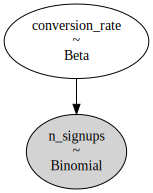

In [34]:
pm.model_to_graphviz(website_a_model)

In [35]:
with website_a_model:
    website_a_idata = pm.sample(draws=1000, tune=1000)
    website_a_idata.extend(pm.sample_prior_predictive(samples=1000))
    website_a_idata.extend(pm.sample_posterior_predictive(website_a_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

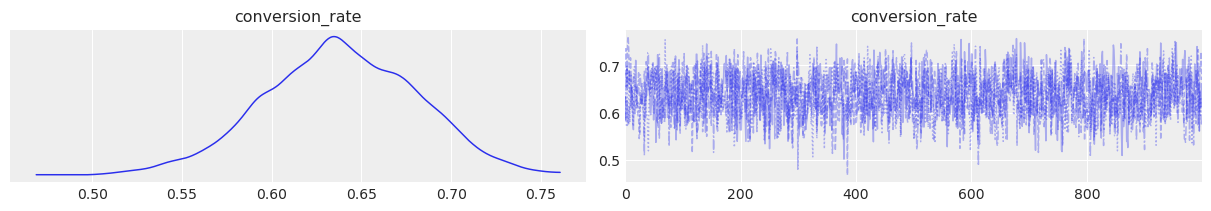

In [36]:
az.plot_trace(website_a_idata, var_names=["conversion_rate"], combined=True)

In [37]:
az.summary(website_a_idata, var_names=["conversion_rate"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
conversion_rate,0.638,0.043,0.557,0.717,0.001,0.001,1572.0,3079.0,1.0


array([<AxesSubplot:title={'center':'conversion_rate\n0'}>,
       <AxesSubplot:title={'center':'conversion_rate\n1'}>,
       <AxesSubplot:title={'center':'conversion_rate\n2'}>,
       <AxesSubplot:title={'center':'conversion_rate\n3'}>], dtype=object)

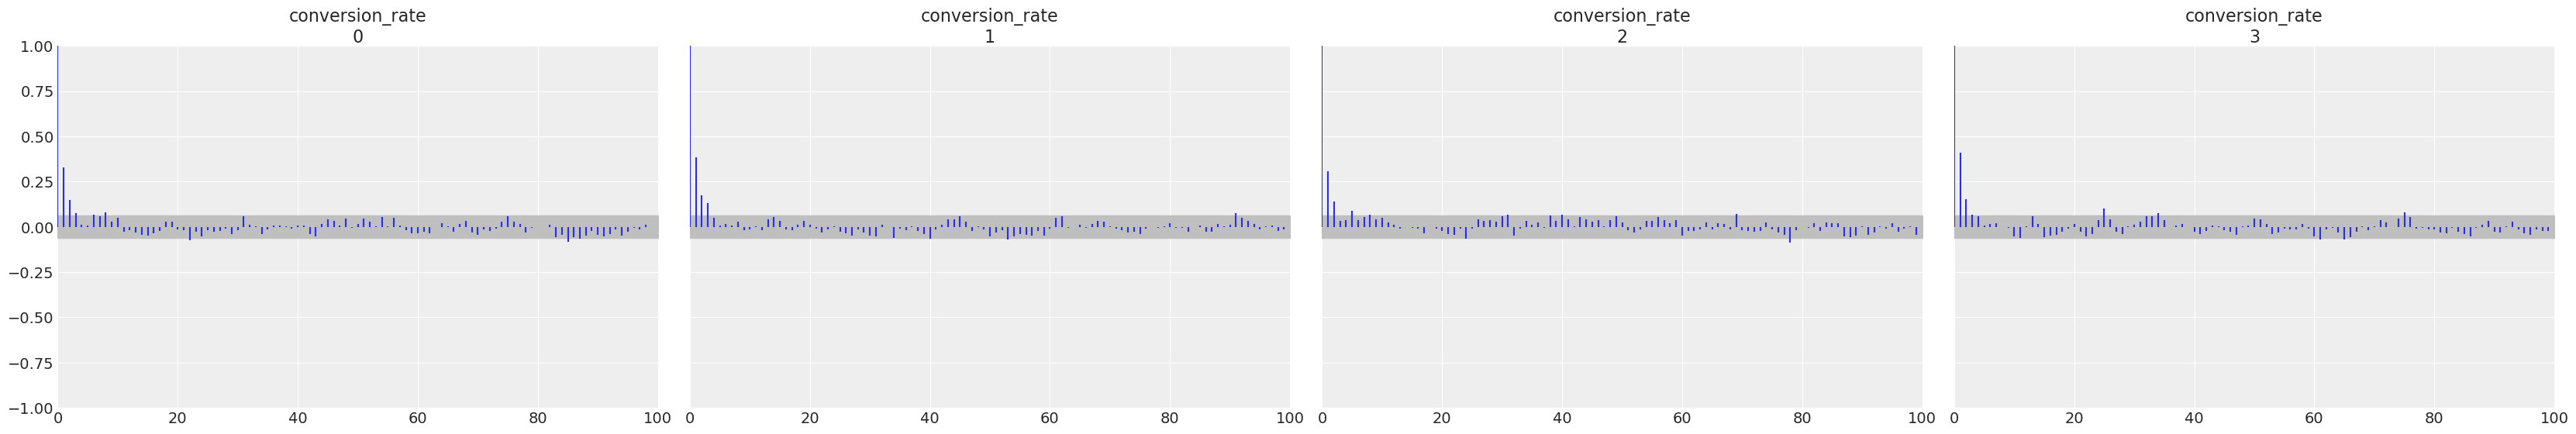

In [38]:
az.plot_autocorr(website_a_idata, var_names=["conversion_rate"])

<AxesSubplot:title={'center':'conversion_rate'}>

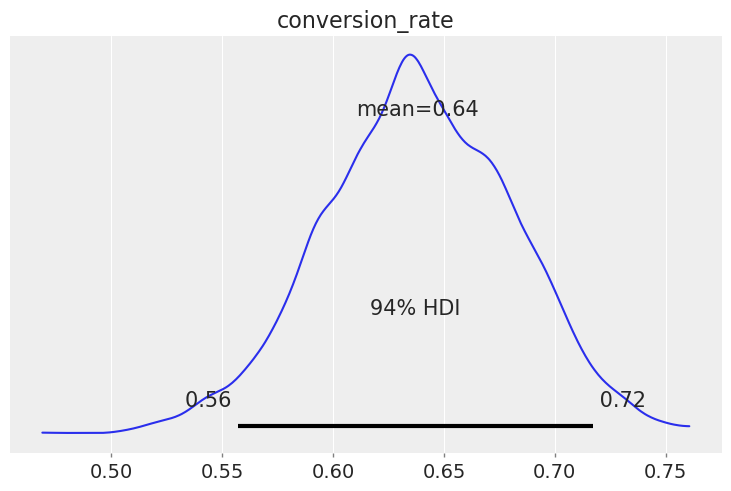

In [39]:
az.plot_posterior(website_a_idata, var_names=["conversion_rate"])

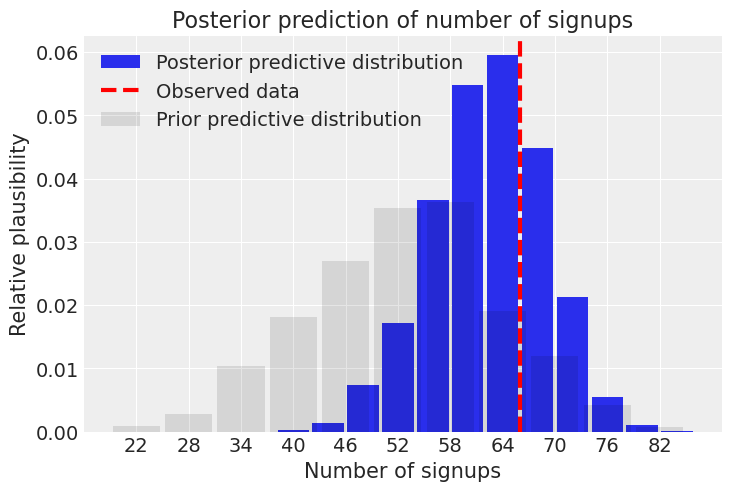

In [42]:
ax = az.plot_dist(
    website_a_idata.posterior_predictive["n_signups"],
    label="Posterior predictive distribution",
)

ax.axvline(
    website_a_idata.observed_data["n_signups"],
    color="red",
    ls="--",
    linewidth=3,
    label="Observed data",
)

az.plot_dist(
    website_a_idata.prior_predictive["n_signups"],
    label="Prior predictive distribution",
    hist_kwargs={"alpha": 0.1},
    color="black",
    ax=ax
)

ax.set(
    xlabel="Number of signups",
    ylabel="Relative plausibility",
    title="Posterior prediction of number of signups"
)
ax.legend()